# Intro

When we published the [GHOST paper](https://doi.org/10.1021/acs.jcim.1c00160) on shifting the decision boundary to improve the predictive performance of classification models built on imbalanced datasets, we only considered binary classifiers (e.g. active/inactive, soluble/insoluble, etc.). I was recently asked if the method could be extended to ternary (three-class) classifiers. This post is about doing that.

The code here isn't set up for easy re-use at the moment. It will eventually find its way into the [open-source ghostml package](https://github.com/rinikerlab/GHOST) once we've had a chance to review and test it more thoroughly. 

> *Aside*: the ghostml package is now pip installable: `python -m pip install ghostml` to install it in your environment

In order for this to make sense, I think I should start with some explanation of the way I've approached the problem:

## Using thresholds in ternary problems

Things are a bit more complicated here than with binary classifiers. For the binary case we just have a single threshold which determines whether an instance is predicted to be in class 0 or 1. So, assuming that we optimized based on the probability of class 1, we can formulate the decision as:
```
if probabilities[1] >= threshold:
   prediction = 1
else:
   prediction = 0
```
Before doing any optimization `threshold` is equal to 0.5.

For ternary predictions we have two different decision boundaries and there's no longer a simple threshold; instead the default decision rule can be expressed as:
```
prediction = argmax(probabilities)
```
i.e., the prediction is the class which has the highest predicted probability.
  
> *Aside*: the same decision rule can be used for a binary classifier with the default threshold. It's just easier to explain using the threshold of 0.5.
  
If we want to introduce two thresholds for the ternary classifier, and assuming that we optimize the thresholds for classes 0 and 2, we have to use a more complex decision rule:
```
        if probabilities[0]>=thresholds[0]:
            # we might still be in class 2 if the relative probability of that
            # is larger than the probability of class 0
            if (probabilities[2]-thresholds[1])>(probabilities[0]-thresholds[0]):
                prediction = 2
            else:
                prediction = 0
        elif probabilities[2]>=thresholds[1]:
            prediction = 0
        else:
            prediction = 1
```

## Optimizing thresholds for ternary problems

For the sake of this post let's assume that we're optimizing the thresholds for classes 0 and 2; we could also do 0 and 1, or 1 and 2, the results should still be the same.

In this post I explore two different approaches for optimizing these thresholds.

### Greedy optimization

Here I optimize the two thresholds independently of each other by constructing two binary classification problems and optimizing the thresholds for those problems. Here's the process:

1. Create a binary classification set by setting the training-set `y` values to 1 if the original value is 0 and to 0 otherwise. 
2. Use the original `ghostml` approach with that binary classification data and the predicted probabilities of each training point to be 0 in order to set `threshold0`, the threshold for the predicted probability of being 0.
3. Create a binary classification set by setting the training-set `y` values to 1 if the original value is 2 and to 0 otherwise. 
4. Use the original `ghostml` approach with that binary classification data and the predicted probabilities of each training point to be 2 in order to set `threshold2`, the threshold for the predicted probability of being 2.

Since the current `ghostml` code doesn't support using balanced accuracy for optimization, I just use kappa for the greedy optimization.

### Grid search

Explore the full grid of possible `(threshold0, threshold2)` pairs and pick the one which produces the optimal Cohen's kappa value. I also try a variant of this which optimizes balanced accuracy instead of Cohen's kappa.

## TL;DR Results summary

Both approaches work well with both simulated data and a couple of datasets from ChEMBL. There doesn't seem to be a large or consistent difference in the quality of the results generated with the two different methods. The greedy optimization approach is, however, quite a bit faster.

Here's the improvement in three scoring metrics (kappa, balanced accuracy, and overall accuracy) when using the greedy optimization procedure on 50 simulated datasets with a 10-80-10 class split; the threshold shift improves both kappa and balanced accuracy on all datasets:
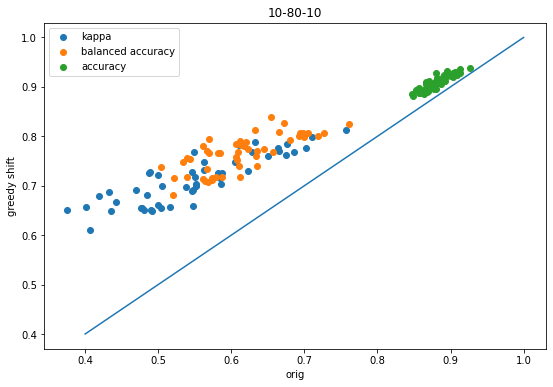

And here's the same plot for 20 different random stratified train/tests splits with target CHEMBL205 (carbonic anhydrase II) with activity thresholds chosen to give a 19-72-9 class split. Once again, the threshold shift improves predictive performance:
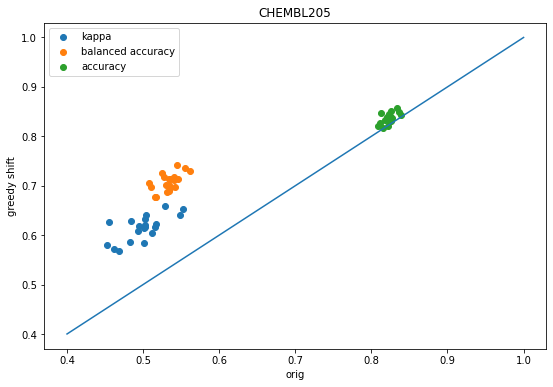


Note: the original version of this [notebook](https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/ghost_multiclass.ipynb) and the two CHEMBL data files ([file1](https://github.com/greglandrum/rdkit_blog/blob/master/data/target_CHEMBL205.csv.gz), [file2](https://github.com/greglandrum/rdkit_blog/blob/master/data/target_CHEMBL217.csv.gz)), are both in github in the [older rdkit blog repo](https://github.com/greglandrum/rdkit_blog).


## Beyond ternary problems

I put some thought into figuring out how to extend this to the general multi-class prediction case, but that turned out to be more difficult than I'd anticipated. If you have suggestions, ideally suggestions accompanied by code, please let me know in the comments!

And now onto the code and more detailed exploration

In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
# note that you can install ghost using pip: python -m pip install ghostml
import ghostml
import pandas as pd
from sklearn import metrics
import numpy as np


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Code we'll use

In [2]:
def ternary_rebin(probs,thresholds):
    ''' returns a list of classifications based on the provided predicted probabilities and thresholds '''
    res = []
    for prob in probs:
        if prob[0]>=thresholds[0]:
            # we might still be in class 2 if the relative probability of that
            # is larger than the probability of class 0
            if (prob[2]-thresholds[1])>(prob[0]-thresholds[0]):
                res.append(2)
            else:
                res.append(0)
        elif prob[2]>=thresholds[1]:
            res.append(2)
        else:
            res.append(1)
    return res

def run_ternary_oob_optimization(oob_probs, labels_train, thresholds, ThOpt_metrics = 'Kappa'):
    ''' does a grid search to optimize the decision thresholds for a ternary problem '''
    res = []
    tscores = []
    for t1 in thresholds:
        for t2 in thresholds:
            preds = ternary_rebin(oob_probs,(t1,t2))
            if ThOpt_metrics == 'Kappa':
                tgt = metrics.cohen_kappa_score(labels_train,preds)
            elif ThOpt_metrics == 'BalancedAccuracy':
                tgt = metrics.balanced_accuracy_score(labels_train,preds)
            elif ThOpt_metrics == 'F1':
                tgt = metrics.f1_score(labels_train,preds)
            tscores.append((np.round(tgt,3),(t1,t2)))
    tscores.sort(reverse=True)
    thresh = tscores[0][-1]
    return thresh


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def run_ternary_experiment(X,y,accum,random_state=0):
    ''' experiment wrapper for the ternary bounds optimization '''
    n_classes = max(y)+1
    local = {}
    
    # --------------------
    # Train - test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, 
                                                        random_state=random_state)

    # --------------------
    # Train a RF classifier
    cls = RandomForestClassifier(n_estimators=500,max_depth=10,oob_score=True,n_jobs=8)
    cls.fit(X_train, y_train)


    # --------------------
    # Calculate the baseline accuracy values
    test_preds = cls.predict(X_test)
    test_probs = cls.predict_proba(X_test)
    kappa = metrics.cohen_kappa_score(y_test,test_preds)
    balanced = metrics.balanced_accuracy_score(y_test,test_preds)
    accuracy = metrics.accuracy_score(y_test,test_preds)
    confusion = metrics.confusion_matrix(y_test,test_preds,labels=list(set(y_test)))
    print('original')
    print(f'accuracy: {accuracy:.3f}  balanced accuracy: {balanced:.3f}  kappa: {kappa:.3f}')
    print(confusion)
    local['orig-accuracy'] = accuracy
    local['orig-balanced'] = balanced
    local['orig-kappa'] = kappa
    local['orig-confusion'] = confusion
    
    # --------------------
    # optimize the two thresholds individually
    thresholds = [0]*(n_classes-1)
    for i,clsv in enumerate((0,2)):
        d_tform = [1 if y==clsv else 0 for y in y_train]
        d_probs = [x[clsv] for x in cls.oob_decision_function_]
        thresholds[i] = ghostml.optimize_threshold_from_oob_predictions(d_tform,d_probs,thresholds=np.arange(0.05,1.0,0.05))
    local['thresholds'] = thresholds
   
    # calculate the accuracy values for those thresholds:
    test_preds = ternary_rebin(test_probs,thresholds)
    kappa = metrics.cohen_kappa_score(y_test,test_preds)
    balanced = metrics.balanced_accuracy_score(y_test,test_preds)
    accuracy = metrics.accuracy_score(y_test,test_preds)
    confusion = metrics.confusion_matrix(y_test,test_preds,labels=list(set(y_test)))
    print('rebalanced')
    print(f'thresholds: {thresholds}')
    print(f'accuracy: {accuracy:.3f}  balanced accuracy: {balanced:.3f}  kappa: {kappa:.3f}')
    print(confusion)
    local['shift-accuracy'] = accuracy
    local['shift-balanced'] = balanced
    local['shift-kappa'] = kappa
    local['shift-confusion'] = confusion
    
    
    # --------------------
    # grid-search optimization of the threshold values based on kappa
    thresholds = run_ternary_oob_optimization(cls.oob_decision_function_,y_train,
                                                   thresholds=np.arange(0.05,1.00,0.05),
                                                  ThOpt_metrics = 'Kappa')
    test_preds = ternary_rebin(test_probs,thresholds)
    kappa = metrics.cohen_kappa_score(y_test,test_preds)
    balanced = metrics.balanced_accuracy_score(y_test,test_preds)
    accuracy = metrics.accuracy_score(y_test,test_preds)
    confusion = metrics.confusion_matrix(y_test,test_preds,labels=list(set(y_test)))
    print('global kappa rebalanced')
    print(f'thresholds: {thresholds}')
    print(f'accuracy: {accuracy:.3f}  balanced accuracy: {balanced:.3f}  kappa: {kappa:.3f}')
    print(confusion)
    local['global-k-shift-accuracy'] = accuracy
    local['global-k-shift-balanced'] = balanced
    local['global-k-shift-kappa'] = kappa
    local['global-k-shift-confusion'] = confusion
    
    # --------------------
    # grid-search optimization of the threshold values based on the balanced accuracy
    thresholds = run_ternary_oob_optimization(cls.oob_decision_function_,y_train,
                                                   thresholds=np.arange(0.05,1.00,0.05),
                                                  ThOpt_metrics = 'BalancedAccuracy')
    test_preds = ternary_rebin(test_probs,thresholds)
    kappa = metrics.cohen_kappa_score(y_test,test_preds)
    balanced = metrics.balanced_accuracy_score(y_test,test_preds)
    accuracy = metrics.accuracy_score(y_test,test_preds)
    confusion = metrics.confusion_matrix(y_test,test_preds,labels=list(set(y_test)))
    print('global balanced_accuracy rebalanced')
    print(f'thresholds: {thresholds}')
    print(f'accuracy: {accuracy:.3f}  balanced accuracy: {balanced:.3f}  kappa: {kappa:.3f}')
    print(confusion)
    local['global-ba-shift-accuracy'] = accuracy
    local['global-ba-shift-balanced'] = balanced
    local['global-ba-shift-kappa'] = kappa
    local['global-ba-shift-confusion'] = confusion
    
    accum.append(local)

# Synthetic datasets


I will try out a couple of real datasets below, but I want to start by verifying that the process works with some synthetic datasest. Scikit-learn's [make_classification() function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) makes this really easy.


## Try a 10-80-10 split

I will test this with multiple different forms of imbalance, just to be sure that it generalizes. Let's start with an example where the majority class is in the middle:

In [4]:
from sklearn.datasets import make_classification

accum_10_80_10 = []

for rep in range(50):
    print('--------------')
    # Generate a ternary imbalanced classification problem
    X, y = make_classification(n_samples=6000, n_features=20,
                               n_informative=10, n_redundant=0, n_classes=3, 
                               random_state=0xf00d+rep, shuffle=False, weights = [0.1, 0.8, 0.1])
    run_ternary_experiment(X,y,accum_10_80_10)


--------------
original
accuracy: 0.865  balanced accuracy: 0.569  kappa: 0.483
[[ 54  69   1]
 [  1 950   1]
 [  4  86  34]]
rebalanced
thresholds: [0.25, 0.2]
accuracy: 0.893  balanced accuracy: 0.763  kappa: 0.682
[[ 77  42   5]
 [ 14 906  32]
 [  7  28  89]]
global kappa rebalanced
thresholds: (0.25, 0.2)
accuracy: 0.893  balanced accuracy: 0.763  kappa: 0.682
[[ 77  42   5]
 [ 14 906  32]
 [  7  28  89]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.844  balanced accuracy: 0.820  kappa: 0.619
[[100  19   5]
 [ 66 814  72]
 [ 10  15  99]]
--------------
original
accuracy: 0.885  balanced accuracy: 0.628  kappa: 0.584
[[ 49  67   7]
 [  1 953   0]
 [  7  56  60]]
rebalanced
thresholds: [0.25, 0.3]
accuracy: 0.920  balanced accuracy: 0.775  kappa: 0.750
[[ 93  26   4]
 [ 11 939   4]
 [ 16  35  72]]
global kappa rebalanced
thresholds: (0.2, 0.25)
accuracy: 0.918  balanced accuracy: 0.798  kappa: 0.756
[[101  18   4]
 [ 22 927   

global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.847  balanced accuracy: 0.819  kappa: 0.621
[[ 96  14  13]
 [ 73 821  62]
 [  5  17  99]]
--------------
original
accuracy: 0.877  balanced accuracy: 0.606  kappa: 0.546
[[ 52  67   4]
 [  0 952   2]
 [  5  69  49]]
rebalanced
thresholds: [0.3, 0.25]
accuracy: 0.898  balanced accuracy: 0.773  kappa: 0.695
[[ 76  40   7]
 [ 18 910  26]
 [  4  27  92]]
global kappa rebalanced
thresholds: (0.3, 0.25)
accuracy: 0.898  balanced accuracy: 0.773  kappa: 0.695
[[ 76  40   7]
 [ 18 910  26]
 [  4  27  92]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.828  balanced accuracy: 0.821  kappa: 0.595
[[ 98  14  11]
 [ 73 792  89]
 [  8  12 103]]
--------------
original
accuracy: 0.858  balanced accuracy: 0.542  kappa: 0.440
[[ 36  83   4]
 [  1 953   0]
 [  1  81  41]]
rebalanced
thresholds: [0.2, 0.25]
accuracy: 0.885  balanced accuracy: 0.73

global kappa rebalanced
thresholds: (0.25, 0.2)
accuracy: 0.893  balanced accuracy: 0.738  kappa: 0.671
[[ 89  28   7]
 [ 20 918  16]
 [  9  48  65]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.1)
accuracy: 0.782  balanced accuracy: 0.791  kappa: 0.521
[[ 96  10  18]
 [ 54 742 158]
 [  9  13 100]]
--------------
original
accuracy: 0.866  balanced accuracy: 0.570  kappa: 0.488
[[ 41  76   5]
 [  2 952   2]
 [  5  71  46]]
rebalanced
thresholds: [0.2, 0.25]
accuracy: 0.906  balanced accuracy: 0.794  kappa: 0.723
[[ 92  22   8]
 [ 12 913  31]
 [ 11  29  82]]
global kappa rebalanced
thresholds: (0.2, 0.25)
accuracy: 0.906  balanced accuracy: 0.794  kappa: 0.723
[[ 92  22   8]
 [ 12 913  31]
 [ 11  29  82]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.863  balanced accuracy: 0.824  kappa: 0.654
[[ 95  14  13]
 [ 27 842  87]
 [ 10  13  99]]
--------------
original
accuracy: 0.887  balanced accuracy: 0.632  

global kappa rebalanced
thresholds: (0.25, 0.2)
accuracy: 0.890  balanced accuracy: 0.756  kappa: 0.670
[[ 84  33   6]
 [ 20 906  28]
 [  6  39  78]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.861  balanced accuracy: 0.828  kappa: 0.649
[[109  10   4]
 [ 57 835  62]
 [ 11  23  89]]
--------------
original
accuracy: 0.882  balanced accuracy: 0.618  kappa: 0.564
[[ 48  70   5]
 [  2 953   0]
 [  4  61  57]]
rebalanced
thresholds: [0.25, 0.3]
accuracy: 0.900  balanced accuracy: 0.735  kappa: 0.684
[[ 81  36   6]
 [ 22 929   4]
 [ 11  41  70]]
global kappa rebalanced
thresholds: (0.25, 0.25)
accuracy: 0.902  balanced accuracy: 0.750  kappa: 0.695
[[ 77  35  11]
 [ 22 925   8]
 [  7  35  80]]
global balanced_accuracy rebalanced
thresholds: (0.1, 0.1)
accuracy: 0.784  balanced accuracy: 0.789  kappa: 0.524
[[ 98   9  16]
 [125 747  83]
 [ 13  13  96]]
--------------
original
accuracy: 0.888  balanced accuracy: 0.638  kappa: 0.588
[[

Start by comparing the model-performance metrics kappa, balanced accuracy, and accuracy between the model with the greedy threshold shift based on kappa and the model with "default thresholds".

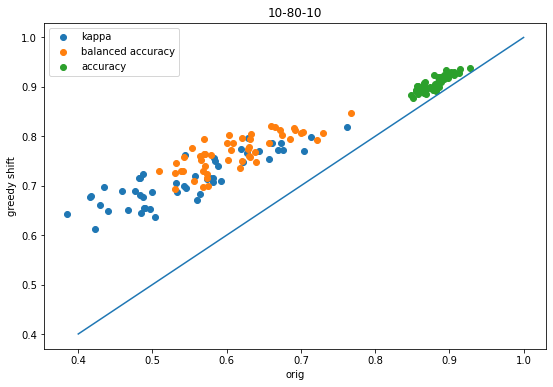

In [5]:
accum = accum_10_80_10
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('10-80-10');

The shift improves all three metrics for every dataset.

Now compare the results for using a grid search based on Cohen's kappa to the greedy shift results:

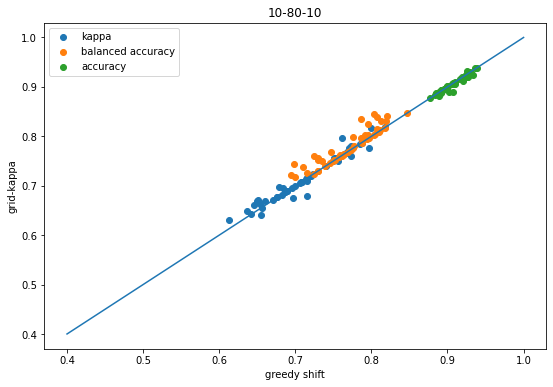

In [6]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('10-80-10');

Here the changes are reasonably small, but they do tend to slightly favor the results of the grid search.

Finally, do the equivalent plot comparing the result from using balanced accuracy in the grid search to the results from the greedy shift:

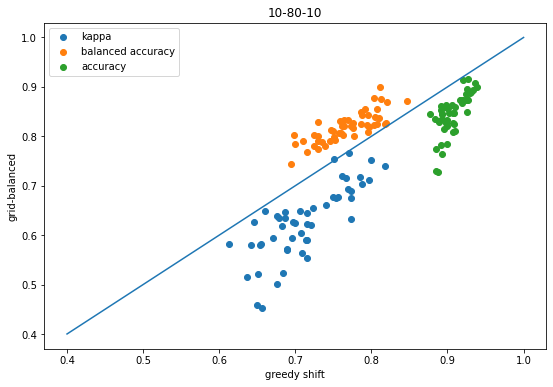

In [7]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('10-80-10');

That plot makes it look like doing the threshold shifts using balanced accuracy doesn't improve kappa, but it's important to remember that this comparing the balanced accuracy shift vs the kappa shift.

Using balanced accuracy to do the shift instead of kappa does actually help kappa too, as this plot shows:

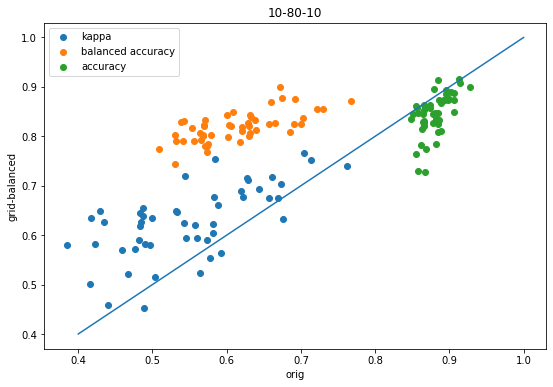

In [8]:
scatter([x['orig-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('grid-balanced');
title('10-80-10');

Still, with these datasets it looks like optimizing the threshold with kappa instead of balanced accuracy is a better idea.

## 0 is the majority class

Now let's make sure that the code doesn't have some "feature" which causes it to only work with the middle class is the majority:

In [9]:
accum_80_10_10 = []

for rep in range(50):
    print('--------------')
    # Generate a ternary imbalanced classification problem
    X, y = make_classification(n_samples=6000, n_features=20,
                               n_informative=10, n_redundant=0, n_classes=3, 
                               random_state=0xf00d+rep, shuffle=False, weights = [0.8, 0.1, 0.1])
    run_ternary_experiment(X,y,accum_80_10_10)


--------------
original
accuracy: 0.883  balanced accuracy: 0.623  kappa: 0.571
[[953   0   1]
 [ 64  54   4]
 [ 67   4  53]]
rebalanced
thresholds: [0.6000000000000001, 0.3]
accuracy: 0.911  balanced accuracy: 0.745  kappa: 0.723
[[939  10   5]
 [ 30  76  16]
 [ 29  17  78]]
global kappa rebalanced
thresholds: (0.6000000000000001, 0.3)
accuracy: 0.911  balanced accuracy: 0.745  kappa: 0.723
[[939  10   5]
 [ 30  76  16]
 [ 29  17  78]]
global balanced_accuracy rebalanced
thresholds: (0.8, 0.3)
accuracy: 0.812  balanced accuracy: 0.756  kappa: 0.556
[[798 151   5]
 [  9  97  16]
 [ 13  32  79]]
--------------
original
accuracy: 0.875  balanced accuracy: 0.596  kappa: 0.526
[[953   1   0]
 [ 71  51   1]
 [ 74   3  46]]
rebalanced
thresholds: [0.7000000000000001, 0.25]
accuracy: 0.904  balanced accuracy: 0.778  kappa: 0.714
[[916  30   8]
 [ 21  94   8]
 [ 37  11  75]]
global kappa rebalanced
thresholds: (0.7000000000000001, 0.25)
accuracy: 0.904  balanced accuracy: 0.778  kappa: 0.714
[

global kappa rebalanced
thresholds: (0.6500000000000001, 0.25)
accuracy: 0.930  balanced accuracy: 0.825  kappa: 0.792
[[933  13  10]
 [ 15  91  17]
 [ 23   6  92]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.2)
accuracy: 0.897  balanced accuracy: 0.836  kappa: 0.725
[[883  44  29]
 [  9  89  25]
 [ 10   7 104]]
--------------
original
accuracy: 0.875  balanced accuracy: 0.613  kappa: 0.542
[[946   8   1]
 [ 69  52   1]
 [ 66   5  52]]
rebalanced
thresholds: [0.6500000000000001, 0.25]
accuracy: 0.882  balanced accuracy: 0.739  kappa: 0.647
[[902  36  17]
 [ 41  70  11]
 [ 31   6  86]]
global kappa rebalanced
thresholds: (0.6500000000000001, 0.25)
accuracy: 0.882  balanced accuracy: 0.739  kappa: 0.647
[[902  36  17]
 [ 41  70  11]
 [ 31   6  86]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.2)
accuracy: 0.847  balanced accuracy: 0.767  kappa: 0.605
[[842  74  39]
 [ 25  77  20]
 [ 14  12  97]]
--------------
original
accuracy: 0.858 

original
accuracy: 0.877  balanced accuracy: 0.597  kappa: 0.543
[[955   0   0]
 [ 67  51   5]
 [ 64  12  46]]
rebalanced
thresholds: [0.7000000000000001, 0.25]
accuracy: 0.907  balanced accuracy: 0.765  kappa: 0.722
[[927  27   1]
 [ 25  74  24]
 [ 25   9  88]]
global kappa rebalanced
thresholds: (0.6500000000000001, 0.3)
accuracy: 0.910  balanced accuracy: 0.754  kappa: 0.722
[[935  19   1]
 [ 30  76  17]
 [ 29  12  81]]
global balanced_accuracy rebalanced
thresholds: (0.8, 0.25)
accuracy: 0.861  balanced accuracy: 0.783  kappa: 0.643
[[855  99   1]
 [  9  90  24]
 [ 14  20  88]]
--------------
original
accuracy: 0.869  balanced accuracy: 0.578  kappa: 0.493
[[953   0   2]
 [ 79  43   1]
 [ 75   0  47]]
rebalanced
thresholds: [0.7000000000000001, 0.25]
accuracy: 0.894  balanced accuracy: 0.775  kappa: 0.691
[[904  36  15]
 [ 22  94   7]
 [ 35  12  75]]
global kappa rebalanced
thresholds: (0.7000000000000001, 0.2)
accuracy: 0.893  balanced accuracy: 0.775  kappa: 0.690
[[903  25  27]


global kappa rebalanced
thresholds: (0.6000000000000001, 0.25)
accuracy: 0.912  balanced accuracy: 0.763  kappa: 0.728
[[934  15   7]
 [ 22  82  18]
 [ 34  10  78]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.25)
accuracy: 0.873  balanced accuracy: 0.775  kappa: 0.661
[[876  73   7]
 [ 12  92  18]
 [ 17  25  80]]
--------------
original
accuracy: 0.908  balanced accuracy: 0.707  kappa: 0.686
[[952   0   2]
 [ 55  64   4]
 [ 43   6  74]]
rebalanced
thresholds: [0.7000000000000001, 0.3]
accuracy: 0.922  balanced accuracy: 0.811  kappa: 0.770
[[926  24   4]
 [ 19  94  10]
 [ 21  16  86]]
global kappa rebalanced
thresholds: (0.6000000000000001, 0.3)
accuracy: 0.931  balanced accuracy: 0.796  kappa: 0.785
[[945   5   4]
 [ 27  86  10]
 [ 26  11  86]]
global balanced_accuracy rebalanced
thresholds: (0.7500000000000001, 0.3)
accuracy: 0.902  balanced accuracy: 0.812  kappa: 0.727
[[898  52   4]
 [ 15  98  10]
 [ 18  19  86]]
--------------
original
accuracy: 0.864  

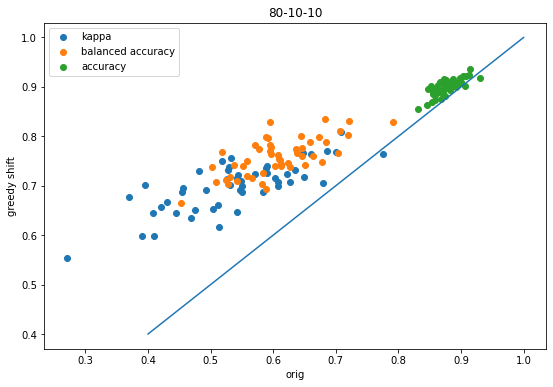

In [10]:
accum = accum_80_10_10
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('80-10-10');

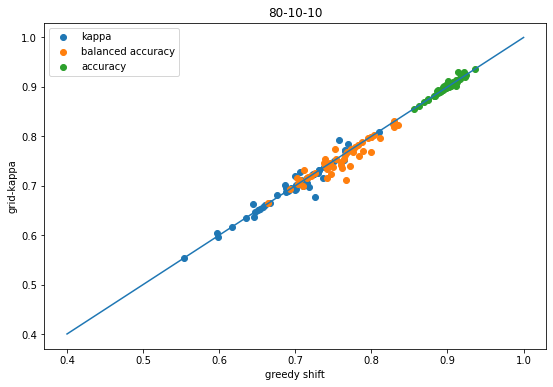

In [11]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('80-10-10');

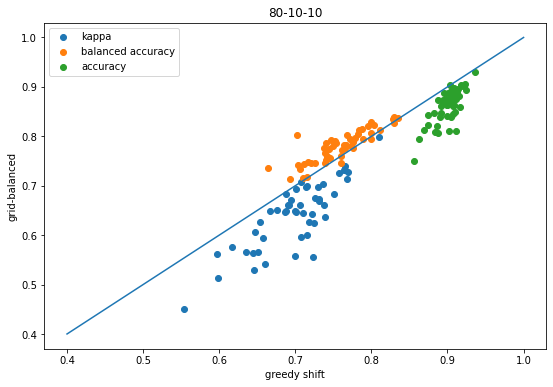

In [12]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('80-10-10');

Same conclusions as before (good thing!)

## 2 is the majority class

In [13]:
accum_10_10_80 = []

for rep in range(50):
    print('--------------')
    # Generate a ternary imbalanced classification problem
    X, y = make_classification(n_samples=6000, n_features=20,
                               n_informative=10, n_redundant=0, n_classes=3, 
                               random_state=0xf00d+rep, shuffle=False, weights = [0.1, 0.1, 0.8])
    run_ternary_experiment(X,y,accum_10_10_80)


--------------
original
accuracy: 0.877  balanced accuracy: 0.604  kappa: 0.534
[[ 54   1  69]
 [  1  46  74]
 [  3   0 952]]
rebalanced
thresholds: [0.3, 0.7000000000000001]
accuracy: 0.893  balanced accuracy: 0.742  kappa: 0.681
[[ 74  25  25]
 [  8  81  32]
 [ 10  28 917]]
global kappa rebalanced
thresholds: (0.25, 0.7000000000000001)
accuracy: 0.897  balanced accuracy: 0.755  kappa: 0.694
[[ 84  15  25]
 [ 13  76  32]
 [ 16  22 917]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.8)
accuracy: 0.840  balanced accuracy: 0.767  kappa: 0.597
[[ 95  16  13]
 [ 21  80  20]
 [ 34  88 833]]
--------------
original
accuracy: 0.857  balanced accuracy: 0.534  kappa: 0.425
[[ 47   0  76]
 [  3  27  93]
 [  0   0 954]]
rebalanced
thresholds: [0.25, 0.7000000000000001]
accuracy: 0.897  balanced accuracy: 0.791  kappa: 0.705
[[ 79  10  34]
 [ 11  97  15]
 [ 11  43 900]]
global kappa rebalanced
thresholds: (0.25, 0.6500000000000001)
accuracy: 0.906  balanced accuracy: 0.767  kappa: 0.712


global kappa rebalanced
thresholds: (0.25, 0.6500000000000001)
accuracy: 0.901  balanced accuracy: 0.779  kappa: 0.708
[[ 86   7  30]
 [ 14  84  25]
 [ 16  27 911]]
global balanced_accuracy rebalanced
thresholds: (0.15000000000000002, 0.8)
accuracy: 0.832  balanced accuracy: 0.790  kappa: 0.595
[[104   4  15]
 [ 31  83   9]
 [ 64  79 811]]
--------------
original
accuracy: 0.881  balanced accuracy: 0.611  kappa: 0.558
[[ 51   4  68]
 [  7  51  64]
 [  0   0 955]]
rebalanced
thresholds: [0.25, 0.6500000000000001]
accuracy: 0.901  balanced accuracy: 0.742  kappa: 0.691
[[ 87   7  29]
 [ 13  67  42]
 [  4  24 927]]
global kappa rebalanced
thresholds: (0.25, 0.6000000000000001)
accuracy: 0.907  balanced accuracy: 0.731  kappa: 0.699
[[ 85   4  34]
 [ 13  63  46]
 [  2  12 941]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.7500000000000001)
accuracy: 0.863  balanced accuracy: 0.755  kappa: 0.627
[[ 96   7  20]
 [ 25  70  27]
 [ 20  66 869]]
--------------
original
accuracy: 0.859

original
accuracy: 0.839  balanced accuracy: 0.479  kappa: 0.326
[[ 41   0  83]
 [  3  13 107]
 [  0   0 953]]
rebalanced
thresholds: [0.25, 0.7000000000000001]
accuracy: 0.879  balanced accuracy: 0.705  kappa: 0.623
[[ 76   9  39]
 [  6  67  50]
 [ 13  28 912]]
global kappa rebalanced
thresholds: (0.2, 0.7000000000000001)
accuracy: 0.880  balanced accuracy: 0.710  kappa: 0.627
[[ 83   3  38]
 [ 11  62  50]
 [ 22  20 911]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.8)
accuracy: 0.800  balanced accuracy: 0.740  kappa: 0.521
[[ 88  20  16]
 [ 11  84  28]
 [ 24 141 788]]
--------------
original
accuracy: 0.887  balanced accuracy: 0.634  kappa: 0.581
[[ 52   1  70]
 [  1  59  63]
 [  1   0 953]]
rebalanced
thresholds: [0.25, 0.6500000000000001]
accuracy: 0.913  balanced accuracy: 0.789  kappa: 0.740
[[ 93   8  22]
 [ 13  79  31]
 [ 12  18 924]]
global kappa rebalanced
thresholds: (0.3, 0.6000000000000001)
accuracy: 0.907  balanced accuracy: 0.739  kappa: 0.705
[[ 74  12  37]
 

global kappa rebalanced
thresholds: (0.25, 0.6500000000000001)
accuracy: 0.922  balanced accuracy: 0.815  kappa: 0.766
[[103   5  14]
 [  7  77  38]
 [ 15  14 927]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.8)
accuracy: 0.851  balanced accuracy: 0.842  kappa: 0.641
[[108  11   3]
 [ 12  96  14]
 [ 28 111 817]]
--------------
original
accuracy: 0.860  balanced accuracy: 0.547  kappa: 0.449
[[ 54   0  69]
 [  5  25  93]
 [  1   0 953]]
rebalanced
thresholds: [0.25, 0.7000000000000001]
accuracy: 0.901  balanced accuracy: 0.772  kappa: 0.706
[[101  10  12]
 [ 13  66  44]
 [ 17  23 914]]
global kappa rebalanced
thresholds: (0.25, 0.6500000000000001)
accuracy: 0.902  balanced accuracy: 0.737  kappa: 0.693
[[101   7  15]
 [ 13  51  59]
 [ 14   9 931]]
global balanced_accuracy rebalanced
thresholds: (0.2, 0.8)
accuracy: 0.819  balanced accuracy: 0.797  kappa: 0.573
[[111   5   7]
 [ 18  81  24]
 [ 35 128 791]]
--------------
original
accuracy: 0.851  balanced accuracy: 0.518  kap

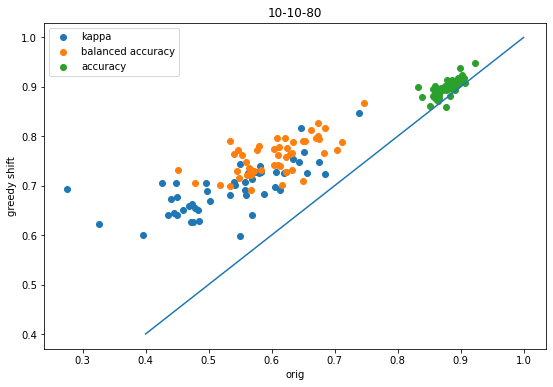

In [14]:
accum = accum_10_10_80
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('10-10-80');

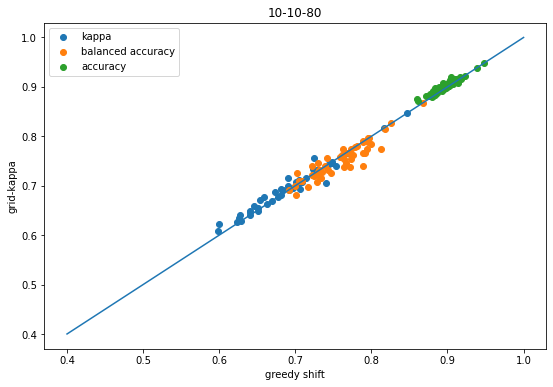

In [15]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('10-10-80');

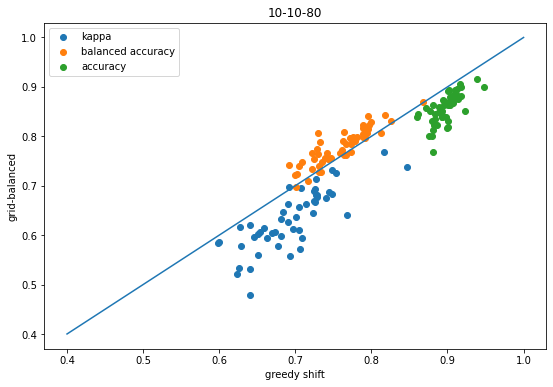

In [16]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('10-10-80');

Same conclusions as before (good thing!)

# Some ChEMBL datasets

Let's just be sure that this approach works with bioactivity data too. I don't think it's necessary do a comprehensive evaluation here, but I want to show a couple of examples. I didn't cherry pick these.

## CHEMBL205: Carbonic Anhydrase II

,compound_chembl_id,canonical_smiles,standard_value,standard_units,standard_relation,standard_type,year,ROMol,pKi
0,CHEMBL1054,NS(=O)(=O)c1cc2c(cc1Cl)NC(C(Cl)Cl)NS2(=O)=O,91.0,nM,=,Ki,2009,,7.040959
1,CHEMBL1055,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,138.0,nM,=,Ki,2009,,6.860121
2,CHEMBL1060,O=P([O-])([O-])O.[Na+].[Na+],13200000.0,nM,=,Ki,2004,,1.879426
3,CHEMBL106848,NS(=O)(=O)c1ccc(SCCO)cc1,21.0,nM,=,Ki,2013,,7.677781
4,CHEMBL107217,CCN(CC)C(=S)[S-].[Na+],3100.0,nM,=,Ki,2009,,5.508638

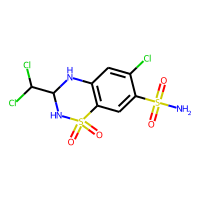
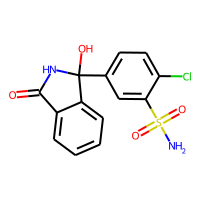
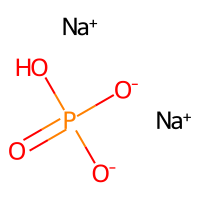
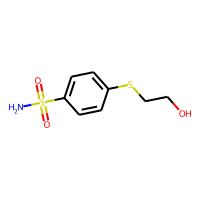
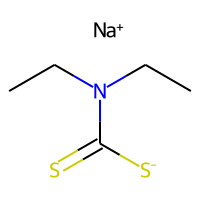

In [4]:
data = pd.read_csv('../data/target_CHEMBL205.csv.gz')
PandasTools.AddMoleculeColumnToFrame(data,smilesCol='canonical_smiles')
data['pKi'] = [-math.log10(x*1e-9) for x in data['standard_value']]
data.head()

Pick two pKi values for binning

In [5]:
def binner(act,bins=(5,8.5)):
    for i,bin in enumerate(bins):
        if act<=bin:
            return i
    return len(bins)
data['activity'] = [binner(x) for x in data.pKi]
data.groupby('activity').describe()

standard_value                                                     \
                  count          mean           std        min         25%   
activity                                                                     
0                 968.0  1.242009e+18  3.864224e+19  10000.000  10000.0000   
1                3582.0  7.292523e+02  1.778519e+03      3.200     13.5000   
2                 427.0  1.309327e+00  8.709364e-01      0.008      0.6355   

                                               year               ...          \
              50%         75%           max   count         mean  ...     75%   
activity                                                          ...           
0         50000.0  196700.000  1.202264e+21   968.0  2012.994835  ...  2016.0   
1            73.4     417.750  9.900000e+03  3582.0  2013.261307  ...  2017.0   
2             1.0       2.035  3.100000e+00   427.0  2014.962529  ...  2017.0   

                     pKi                                                     \
             max   count      mean       std        min       25%       50%   
activity                                                                      
0         2020.0   968.0  4.069107  1.200449 -12.080000  3.706216  4.301030   
1         2020.0  3582.0  7.050231  0.915651   5.004365  6.379084  7.134306   
2         2020.0   427.0  9.050659  0.500779   8.508638  8.691437  9.000000   

                              
               75%       max  
activity                      
0         5.000000   5.00000  
1         7.869666   8.49485  
2         9.196895  11.09691  

[3 rows x 24 columns]

Ok, that's imbalanced :-)

Generate fingerprints:

In [6]:
from rdkit.Chem import SaltRemover
sr = SaltRemover.SaltRemover()
stripped = [sr.StripMol(m) for m in data.ROMol]
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
fps = [fpgen.GetFingerprint(m) for m in stripped]

And now run the experiment with 20 random splits:

In [7]:
accum_chembl205 = []
for i in range(20):
    run_ternary_experiment(fps,data.activity,accum_chembl205,random_state=0xf00d+i)


original
accuracy: 0.833  balanced accuracy: 0.547  kappa: 0.530
[[126  68   0]
 [ 14 703   0]
 [  0  84   1]]
rebalanced
thresholds: [0.4, 0.15000000000000002]
accuracy: 0.851  balanced accuracy: 0.719  kappa: 0.647
[[154  38   2]
 [ 39 656  22]
 [  0  47  38]]
global kappa rebalanced
thresholds: (0.4, 0.15000000000000002)
accuracy: 0.851  balanced accuracy: 0.719  kappa: 0.647
[[154  38   2]
 [ 39 656  22]
 [  0  47  38]]
global balanced_accuracy rebalanced
thresholds: (0.3, 0.1)
accuracy: 0.712  balanced accuracy: 0.776  kappa: 0.493
[[177  12   5]
 [ 96 467 154]
 [  3  17  65]]
original
accuracy: 0.822  balanced accuracy: 0.538  kappa: 0.497
[[117  77   0]
 [ 17 699   1]
 [  0  82   3]]
rebalanced
thresholds: [0.4, 0.15000000000000002]
accuracy: 0.837  balanced accuracy: 0.723  kappa: 0.622
[[149  45   0]
 [ 41 642  34]
 [  1  41  43]]
global kappa rebalanced
thresholds: (0.4, 0.15000000000000002)
accuracy: 0.837  balanced accuracy: 0.723  kappa: 0.622
[[149  45   0]
 [ 41 642  34]

original
accuracy: 0.822  balanced accuracy: 0.534  kappa: 0.502
[[122  72   0]
 [ 20 697   0]
 [  3  82   0]]
rebalanced
thresholds: [0.4, 0.15000000000000002]
accuracy: 0.827  balanced accuracy: 0.701  kappa: 0.598
[[149  45   0]
 [ 53 637  27]
 [  2  45  38]]
global kappa rebalanced
thresholds: (0.4, 0.15000000000000002)
accuracy: 0.827  balanced accuracy: 0.701  kappa: 0.598
[[149  45   0]
 [ 53 637  27]
 [  2  45  38]]
global balanced_accuracy rebalanced
thresholds: (0.3, 0.1)
accuracy: 0.757  balanced accuracy: 0.791  kappa: 0.543
[[175  19   0]
 [ 98 515 104]
 [  2  19  64]]
original
accuracy: 0.827  balanced accuracy: 0.541  kappa: 0.517
[[126  68   0]
 [ 19 698   0]
 [  2  83   0]]
rebalanced
thresholds: [0.4, 0.15000000000000002]
accuracy: 0.831  balanced accuracy: 0.709  kappa: 0.614
[[159  34   1]
 [ 54 633  30]
 [  3  46  36]]
global kappa rebalanced
thresholds: (0.4, 0.15000000000000002)
accuracy: 0.831  balanced accuracy: 0.709  kappa: 0.614
[[159  34   1]
 [ 54 633  30]

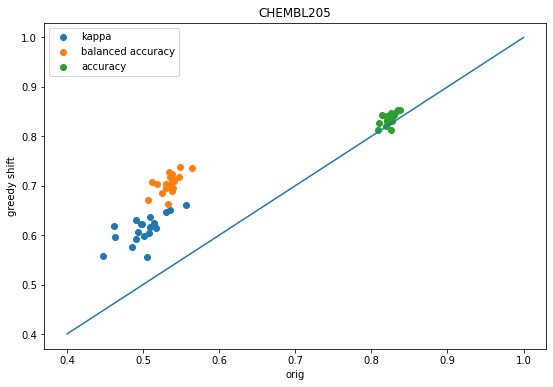

In [8]:
accum = accum_chembl205
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('CHEMBL205');

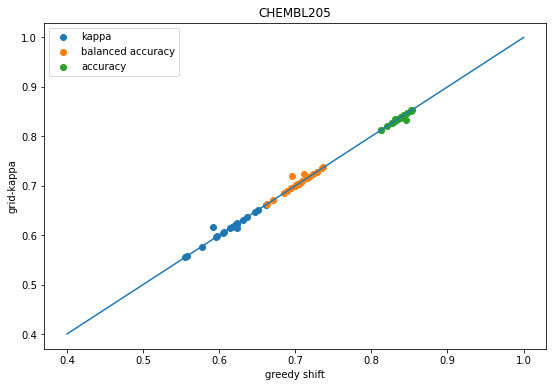

In [9]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('CHEMBL205');

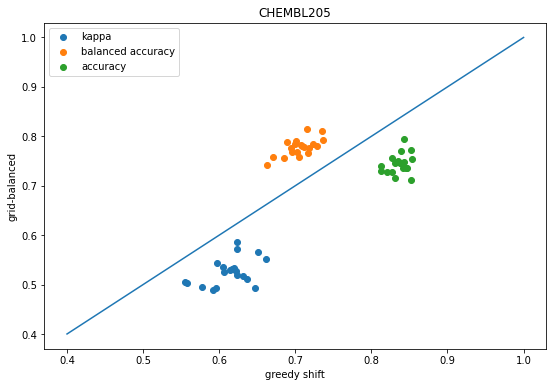

In [10]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('CHEMBL205');

We see the same behavior as before: shifting the descision thresholds using either the greedy approach or grid-based approach improves prediction accuracy over the default decision thresholds.


## CHEMBL217: Dopamine D2

In [11]:
data = pd.read_csv('../data/target_CHEMBL217.csv.gz')
PandasTools.AddMoleculeColumnToFrame(data,smilesCol='canonical_smiles')
data['pKi'] = [-math.log10(x*1e-9) for x in data['standard_value']]
def binner(act,bins=(5,8)):
    for i,bin in enumerate(bins):
        if act<=bin:
            return i
    return len(bins)
data['activity'] = [binner(x) for x in data.pKi]
data.groupby('activity').describe()

standard_value                                                       \
                  count           mean            std        min         25%   
activity                                                                       
0                 356.0  143415.189354  781194.668326  10000.000  10000.0000   
1                4014.0     830.546163    1471.610125     10.000     63.1875   
2                 607.0       3.715942       2.786155      0.027      1.2150   

                                            year               ...          \
               50%      75%          max   count         mean  ...     75%   
activity                                                       ...           
0         10000.00  24234.5  10000000.00   356.0  2011.679775  ...  2017.0   
1           238.51    931.0      9906.00  4014.0  2011.100648  ...  2015.0   
2             3.00      5.9         9.86   607.0  2011.957166  ...  2016.0   

                     pKi                                                    \
             max   count      mean       std       min       25%       50%   
activity                                                                     
0         2019.0   356.0  4.672916  0.581865  2.000000  4.615626  5.000000   
1         2020.0  4014.0  6.620074  0.724919  5.004102  6.031050  6.622494   
2         2019.0   607.0  8.614671  0.475862  8.006123  8.229148  8.522879   

                               
               75%        max  
activity                       
0         5.000000   5.000000  
1         7.199370   8.000000  
2         8.915457  10.568636  

[3 rows x 24 columns]

In [12]:
from rdkit.Chem import SaltRemover
sr = SaltRemover.SaltRemover()
stripped = [sr.StripMol(m) for m in data.ROMol]
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
fps = [fpgen.GetFingerprint(m) for m in stripped]

In [13]:
accum_chembl217 = []
for i in range(20):
    run_ternary_experiment(fps,data.activity,accum_chembl217,random_state=0xf00d+i)


original
accuracy: 0.832  balanced accuracy: 0.436  kappa: 0.239
[[  9  62   0]
 [  0 797   6]
 [  0  99  23]]
rebalanced
thresholds: [0.1, 0.15000000000000002]
accuracy: 0.810  balanced accuracy: 0.657  kappa: 0.453
[[ 33  38   0]
 [ 33 696  74]
 [  0  44  78]]
global kappa rebalanced
thresholds: (0.15000000000000002, 0.15000000000000002)
accuracy: 0.819  balanced accuracy: 0.601  kappa: 0.434
[[ 19  52   0]
 [ 10 719  74]
 [  0  44  78]]
global balanced_accuracy rebalanced
thresholds: (0.1, 0.1)
accuracy: 0.706  balanced accuracy: 0.665  kappa: 0.353
[[ 33  29   9]
 [ 31 570 202]
 [  0  22 100]]
original
accuracy: 0.832  balanced accuracy: 0.426  kappa: 0.234
[[  5  66   0]
 [  3 798   2]
 [  0  96  26]]
rebalanced
thresholds: [0.1, 0.2]
accuracy: 0.845  balanced accuracy: 0.693  kappa: 0.524
[[ 43  28   0]
 [ 36 730  37]
 [  0  53  69]]
global kappa rebalanced
thresholds: (0.1, 0.2)
accuracy: 0.845  balanced accuracy: 0.693  kappa: 0.524
[[ 43  28   0]
 [ 36 730  37]
 [  0  53  69]]

global balanced_accuracy rebalanced
thresholds: (0.1, 0.15000000000000002)
accuracy: 0.829  balanced accuracy: 0.725  kappa: 0.527
[[ 41  30   0]
 [ 36 696  71]
 [  1  32  89]]
original
accuracy: 0.837  balanced accuracy: 0.452  kappa: 0.274
[[ 10  61   0]
 [  2 797   4]
 [  0  95  27]]
rebalanced
thresholds: [0.1, 0.2]
accuracy: 0.846  balanced accuracy: 0.697  kappa: 0.534
[[ 41  30   0]
 [ 32 728  43]
 [  2  46  74]]
global kappa rebalanced
thresholds: (0.1, 0.2)
accuracy: 0.846  balanced accuracy: 0.697  kappa: 0.534
[[ 41  30   0]
 [ 32 728  43]
 [  2  46  74]]
global balanced_accuracy rebalanced
thresholds: (0.1, 0.1)
accuracy: 0.730  balanced accuracy: 0.709  kappa: 0.395
[[ 41  28   2]
 [ 31 586 186]
 [  2  20 100]]
original
accuracy: 0.840  balanced accuracy: 0.465  kappa: 0.290
[[ 14  57   0]
 [  2 798   3]
 [  0  97  25]]
rebalanced
thresholds: [0.1, 0.2]
accuracy: 0.836  balanced accuracy: 0.669  kappa: 0.497
[[ 37  34   0]
 [ 41 725  37]
 [  0  51  71]]
global kappa rebala

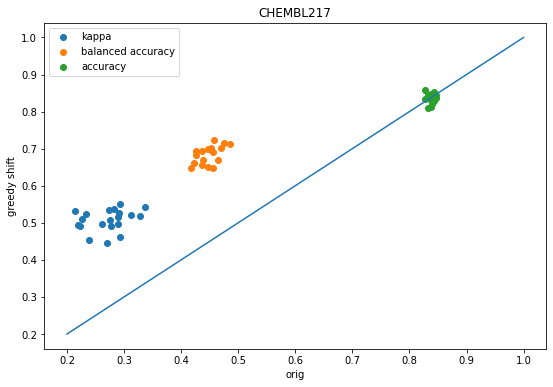

In [14]:
accum = accum_chembl217
figsize(9,6)
scatter([x['orig-kappa'] for x in accum],[x['shift-kappa'] for x in accum],label='kappa');
scatter([x['orig-balanced'] for x in accum],[x['shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['orig-accuracy'] for x in accum],[x['shift-accuracy'] for x in accum],label='accuracy');
plot([.2,1],[.2,1]);
legend();
xlabel('orig')
ylabel('greedy shift');
title('CHEMBL217');

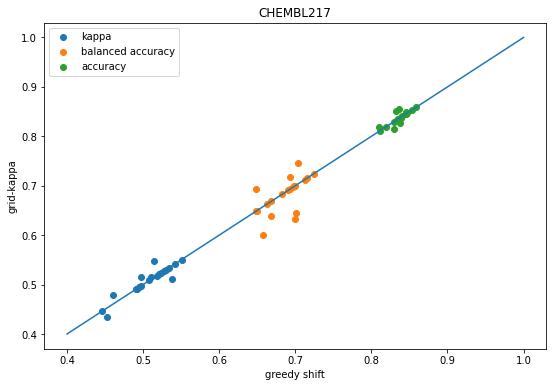

In [15]:
scatter([x['shift-kappa'] for x in accum],[x['global-k-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-k-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-k-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-kappa');
title('CHEMBL217');

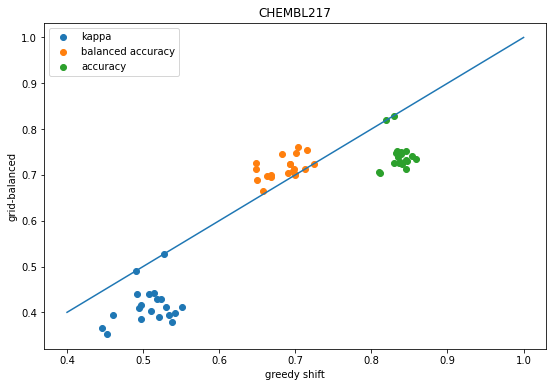

In [16]:
scatter([x['shift-kappa'] for x in accum],[x['global-ba-shift-kappa'] for x in accum],label='kappa');
scatter([x['shift-balanced'] for x in accum],[x['global-ba-shift-balanced'] for x in accum],label='balanced accuracy');
scatter([x['shift-accuracy'] for x in accum],[x['global-ba-shift-accuracy'] for x in accum],label='accuracy');
plot([.4,1],[.4,1]);
legend();
xlabel('greedy shift')
ylabel('grid-balanced');
title('CHEMBL217');

Again, the same conclusions hold here.